# Notes:
* IDs in dm_apps do not conflict with these IDs
    * confirm prior to import to full production Db
    * ALT: redo ID with another format
        * Kevin opinion: it would be nice to have the IDs look completely different between species for readability, but there may be reasons why 12-13 character ids are impractical
    * NB: since dates and sites are encoded into these ID, they may not be compatible with int filetypes
        * dm_apps looks to use char fields with max_length of 100, so should be fine... confirm
* CONFIRM: 
    * format of null samples when unmatched with fish details or length frequencies
    * required distict sample entry to link to for
        * fish details
        * length frequencies
    * no need for null fish details or length frequencies when unmatched with sample data
* WISHLIST
    * in dm_apps, it would be cool to be able to merge samples, or link with details/lengths (to deal with ambiguous data / partial matches)
    * in dm_apps, can we search for lengths/details, or do we need to find the correct sample?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
df_FD = pd.read_pickle('cleaned_MASTER_dataset.pickle')  # fish details
df_LF = pd.read_pickle('cleaned_LENGTHFREQ_dataset.pickle')  # length frequencies
df_SD = pd.read_pickle('cleaned_LOGBOOK_dataset.pickle')  # logbook / sample data

# Generate Unique IDs - Length Frequencies

In [3]:
# replace non-numeric data with made up site numbers
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
# df_LF.loc[df_LF.SITE1.isnull(), 'SITE1'] = 0  # set missing sites to 0
# NOTE: null sites can be set during query (fillna(0))
df_LF = df_LF.replace({'SITE1': id_replacements})

In [4]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [5]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [6]:
# only run this once
if df_LF.id.max() < 2_100_000_000:

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

In [7]:
# LOOKS GOOD: check to see if it worked
df_LF[df_LF.id.isin([x + 1_000_000_000 for x in duplicated_ids_LF]) | df_LF.id.isin([x + 2_000_000_000 for x in duplicated_ids_LF])]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id
3102,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,235,1,235,1998-05-01,5,<NA>,<NA>,2998050105,True,True
3103,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,240,1,240,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3104,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,245,4,245,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3105,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,250,2,250,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3106,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,255,3,255,1998-05-01,5,<NA>,<NA>,2998050105,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,250,25,250,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10849,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,255,13,255,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10850,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,260,1,260,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10851,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,235,2,235,2018-06-13,64,<NA>,<NA>,4018061364,True,False


In [8]:
# GOOD:
df_LF[df_LF.id.isin(duplicated_ids_LF)]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id


# Length Bins

In [9]:
# use the same bins as used in the herring database
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

In [10]:
# error check: how many total fish cm (binned)
(df_LF['length_bin_id'] * df_LF['freq']).sum()

5076496.0

In [11]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

In [12]:
# LOOKS GOOD: error check: how many total fish cm (binned)
(gaspereau_lengthfrequency['length_bin_id'] * gaspereau_lengthfrequency['count']).sum()

5076496.0

# Save the gaspereau_lengthfrequency table

In [13]:
# this can link to herring_lengthbin (it goes from 0 to 200cm - more than enough)
if False:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')

In [14]:
# lets look at a few histograms, just to check
sample_ids = gaspereau_lengthfrequency.sample_id.unique()

----------------------------------------------
Histogram: 1995052815


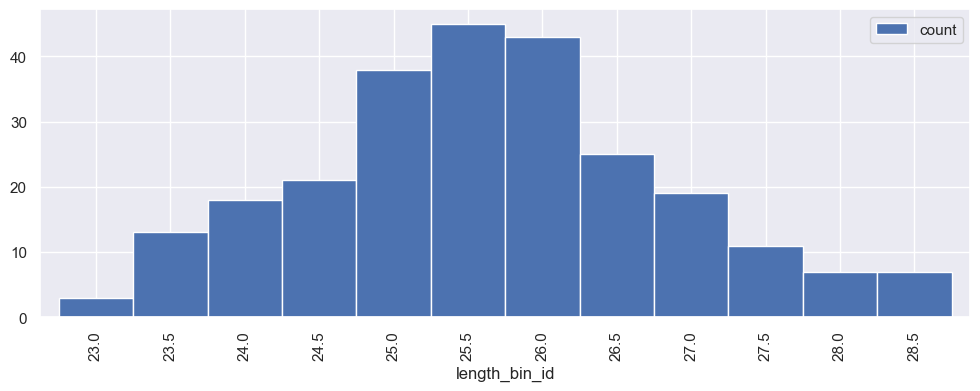

----------------------------------------------
Histogram: 2016060325


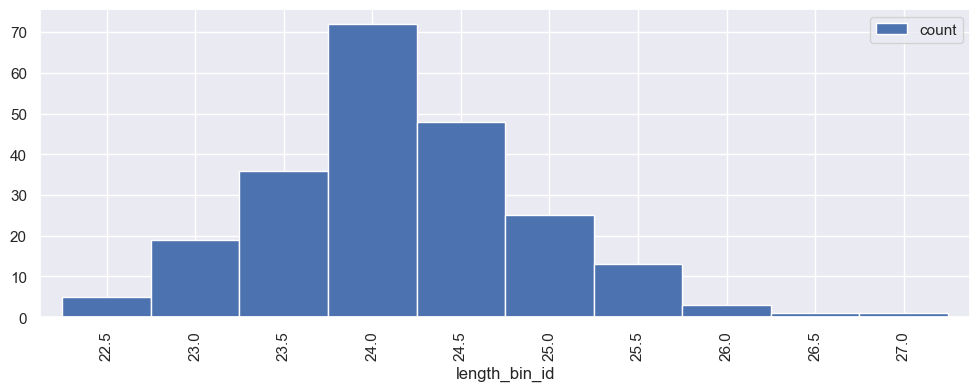

----------------------------------------------
Histogram: 1995060938


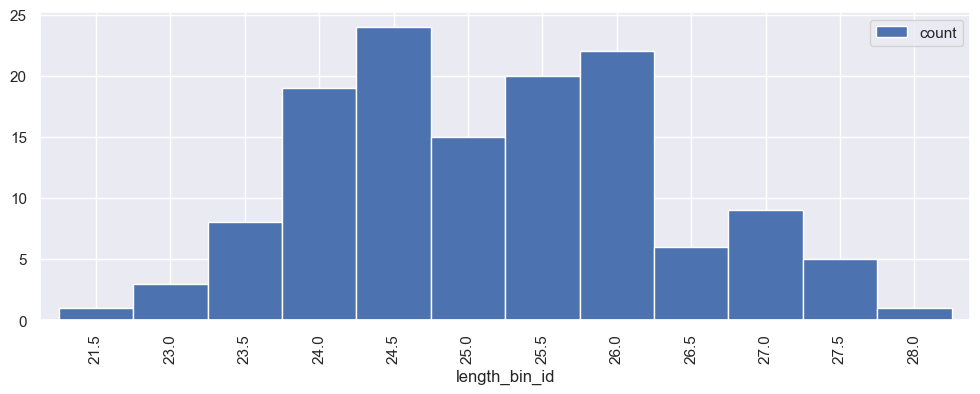

----------------------------------------------
Histogram: 2019062541


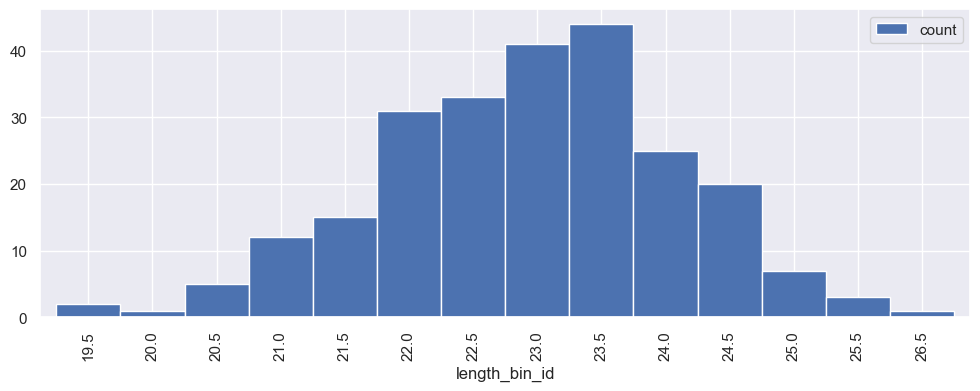

----------------------------------------------
Histogram: 2015052212


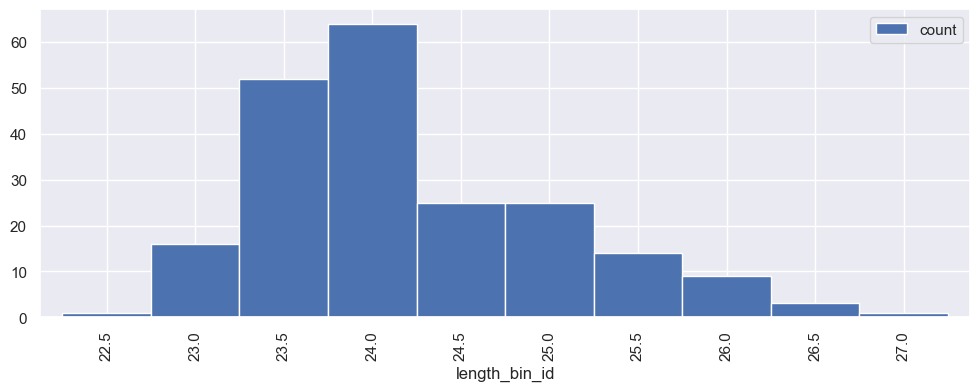

In [15]:
# random samples - check the histogram
for i in range(5):
    sample_id = np.random.choice(sample_ids)
    print('----------------------------------------------\nHistogram:', sample_id)
    gaspereau_lengthfrequency.loc[gaspereau_lengthfrequency.sample_id==sample_id, ['count', 'length_bin_id']].plot(kind='bar', x='length_bin_id', y='count', width=1, figsize=(12,4))
    plt.show()

# Samples

In [16]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [17]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

In [18]:
# check to see if it worked
check_SD = set()
for idx in list(df_SD[df_SD.id > 2_100_000_000].id):
    check_SD.add(idx % 1_000_000_000)

# looks good
check_SD, duplicated_ids_SD

({4061001, 988040037, 988052348, 997061258},
 {1988040037, 1988052348, 1997061258, 2004061001})

In [19]:
# another check, looks good
df_SD[df_SD.id > 2_100_000_000]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
2346,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,36076.000,16363.800,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,2988040037
2452,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,7015.000,3182.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,2988052348
2531,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,4008.000,1818.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,3988040037
2535,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,4008.000,1818.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,3988052348
2570,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,4988040037
2571,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,5988040037
2608,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2405.000,1090.900,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,6988040037
2633,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2004.000,909.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,7988040037
2680,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1503.000,681.700,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,8988040037
2731,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1002.000,454.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,9988040037


In [20]:
# perfect
df_SD[df_SD.duplicated('id')]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id


# add null sample data where there is unmatched length frequencies

In [21]:
df_SD = pd.concat([df_SD, pd.DataFrame(df_LF[~df_LF.id.isin(set(df_SD.id))].id.unique(), columns=['id'])]).reset_index(drop=True)

# NOTE: if a datetime column is useful, pd.to_datetime(id // 100) should work
# alt could use a more complicated JOIN to add SITE1 as well
# leave this way for now

In [22]:
# all LF data are in the SD dataframe
df_LF[~df_LF.id.isin(set(df_SD.id))]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id


# fishdetails IDs

In [23]:
df_FD.SITE.unique()

array(['12', '8', '17', '33', '5', '9', '25', '2', '64', '15', '49', '56',
       nan, '7', '11', '35', '38', '39', '51', '37', '46', '48', '34',
       '4', '23', '67', '1', '26', '28', '6', '52', '29', '1A', '60',
       '60, 52', '41', '1, 8', '37,38,35', '60,52', '1,8', '5,8', '12,17',
       '15,17', '33,48,49', '11,12', '5,11,17', '37,60', '52,60', '38,52',
       '1,8,26', '33,41,60', '35,60', '27', '35,37', '01,02', '41,49',
       '52,60,38', '60,52,35', '41,35', '60,41', '35,41', '38,60,52',
       '49,41', '35,52', '12,26', '2,5', '5,17', '5,26', '25,26', '47',
       '14', '30', '62', '47 or 62', '11K3 (435,211)', 'E.MACFARLANE',
       'Eric MacFarlane', 'JA Coady', 'J McFarlane'], dtype=object)

In [24]:
# replace non-numeric data with made up site numbers
id_replacements_v2 = {
    '1A': 90,
    '1B': 91,
    'Eric MacFarlane': 92,
    'E.MACFARLANE': 92,
    'J McFarlane': 93,
    'JA Coady': 94,
    '11K3 (435,211)': 95, 
    '47 or 62': 47
}

In [25]:
# same site replacements from LF
df_FD['SITE1'] = df_FD.replace({'SITE': id_replacements_v2}).SITE
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE1.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

df_FD['sample_id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE1.fillna(0).astype(int)
).astype('Int64')

# add null sample data where there is unmatched fish details

In [26]:
df_SD = pd.concat([df_SD, pd.DataFrame(df_FD[~df_FD.sample_id.isin(set(df_SD.id))].sample_id.unique(), columns=['id'])]).reset_index(drop=True)
# again, a few more details could be added, but leave for now because the sample data is incomplete either way

In [27]:
# check SD for missing FD data
df_FD[~df_FD.sample_id.isin(set(df_SD.id))].sample_id.unique()

<IntegerArray>
[]
Length: 0, dtype: Int64

In [28]:
# looks good
df_FD.sample(10)

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
29338,2014,5,23,4,62,PM,Frozen,10,<NA>,250,258.000,226.200,A,F,4,23.900,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2014-05-23,62,<NA>,<NA>,2014052362
32241,2016,6,24,8,26,AM,Fresh,4,269,<NA>,269.000,233.900,B,F,4,36.400,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,2016-06-24,26,<NA>,<NA>,2016062426
35093,2019,6,19,8,12,AM,Frozen,12,<NA>,<NA>,NaN,142.700,B,M,4,NaN,JM,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,2019-06-19,12,<NA>,<NA>,2019061912
22242,2006,5,27,4,12,PM,Frozen,12,<NA>,248,256.000,241.300,A,M,4,NaN,NaN,5,2,NaN,NaN,<NA>,<NA>,NaN,NaN,5,2,2006-05-27,12,<NA>,<NA>,2006052712
33692,2018,5,25,4,25,AM,Frozen,12,<NA>,227,235.000,150.400,A,M,4,NaN,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2018-05-25,25,<NA>,<NA>,2018052525
2111,1985,6,6,<NA>,12,NaN,Frozen,2,<NA>,265,273.000,316.000,A,F,2,48.100,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1985-06-06,12,<NA>,<NA>,1985060612
24816,2010,5,19,4,26,AM,Frozen,25,<NA>,280,289.000,327.800,A,F,4,53.800,NaN,7,3,NaN,NaN,<NA>,<NA>,NaN,NaN,7,3,2010-05-19,26,<NA>,<NA>,2010051926
16076,1999,5,7,1,37,PM,Frozen,14,<NA>,258,266.000,251.600,A,F,4,39.100,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1999-05-07,37,<NA>,<NA>,1999050737
19741,2001,6,16,7,38,PM,Frozen,2,<NA>,270,278.000,216.000,B,F,6,8.000,NaN,<NA>,9,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,9,2001-06-16,38,<NA>,<NA>,2001061638
18242,2000,6,7,6,26,PM,Fresh,21,231,<NA>,231.000,157.000,A,F,4,19.400,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2000-06-07,26,<NA>,<NA>,2000060726


# format tables for saving

In [31]:
# import table formats from Excel (cut and paste properties from DBeaver sqlite db)
tables_db_attributes = 'gaspereau database tables.xlsx'

sample_table_attributes = pd.read_excel(tables_db_attributes, sheet_name='samples')
fishdetail_table_attributes = pd.read_excel(tables_db_attributes, sheet_name='fishdetail')
lengthfrequency_table_attributes = pd.read_excel(tables_db_attributes, sheet_name='lengthfrequency')

In [105]:
# get dictionary of dtypes from table, create properly datatyped empty table

# replacement lookup for datatypes formatting
dtype_lookup ={
    'INTEGER': 'Int64',  # use int64 for id and sample_id
    'DATETIME': 'datetime64[ns]',
    'VARCHAR': 'object',
    'REAL': 'float',
    'TEXT': 'object', 
    'BOOL': 'bool'
}

# create dtype dictionary
def df_to_dict_dtypes(dataframe, col_attribute='Column Name', col_dtype='Data Type', replace_dtype_formatting=dtype_lookup):
    """
    NOTES: 
    the to_dict() method doesn't work with this format, used dict(zip()) instead
    the column names are as cut and paste from DBeaver database properties, as are the lookup keys
    lookup values are as utilised in pandas
    """
    return dict(zip(
        dataframe[col_attribute], 
        dataframe.replace({col_dtype: replace_dtype_formatting})[col_dtype]
    ))


# create formatted empty table
def create_formatted_table_dataframe(dataframe, col_attribute='Column Name', col_dtype='Data Type'):
    """
    NOTES
    dataframe can't accept dtypes dictionary (as it does during import) - deprecated as of 0.17
    need to use less readable dict comprehension (or could loop through columns)
    """
    return pd.DataFrame({col: pd.Series(dtype=dt) for col, dt in df_to_dict_dtypes(dataframe).items()})


In [32]:
# Sample Table Format
sample_table_attributes

,Column Name,#,Data Type,Length,Not Null,Auto Increment,Default,Description
0,id,1,INTEGER,[NULL],True,True,[NULL],[NULL]
1,type,2,INTEGER,[NULL],False,False,[NULL],[NULL]
2,sample_date,3,DATETIME,[NULL],True,False,[NULL],[NULL]
3,sampler_ref_number,4,INTEGER,[NULL],False,False,[NULL],[NULL]
4,survey_id,5,VARCHAR,50,False,False,[NULL],[NULL]
5,latitude_n,6,REAL,[NULL],False,False,[NULL],[NULL]
6,longitude_w,7,REAL,[NULL],False,False,[NULL],[NULL]
7,experimental_net_used,8,INTEGER,[NULL],False,False,[NULL],[NULL]
8,vessel_cfvn,9,INTEGER,[NULL],False,False,[NULL],[NULL]
9,catch_weight_lbs,10,REAL,[NULL],False,False,[NULL],[NULL]


In [110]:
create_formatted_table_dataframe(sample_table_attributes).dtypes

id                                      Int64
type                                    int32
sample_date                    datetime64[ns]
sampler_ref_number                      int32
survey_id                              object
latitude_n                            float64
longitude_w                           float64
experimental_net_used                   int32
vessel_cfvn                             int32
catch_weight_lbs                      float64
sample_weight_lbs                     float64
total_fish_measured                     int32
total_fish_preserved                    int32
remarks                                object
old_id                                 object
season                                  int32
lab_processing_complete                  bool
otolith_processing_complete              bool
creation_date                  datetime64[ns]
last_modified_date             datetime64[ns]
created_by_id                           int32
district_id                       

In [33]:
# fish detail
fishdetail_table_attributes

,Column Name,#,Data Type,Length,Not Null,Auto Increment,Default,Description
0,id,1,INTEGER,[NULL],True,True,[NULL],[NULL]
1,fish_number,2,INTEGER,[NULL],True,False,[NULL],[NULL]
2,fish_length,3,REAL,[NULL],False,False,[NULL],[NULL]
3,fish_weight,4,REAL,[NULL],False,False,[NULL],[NULL]
4,gonad_weight,5,REAL,[NULL],False,False,[NULL],[NULL]
5,parasite,6,INTEGER,[NULL],False,False,[NULL],[NULL]
6,lab_processed_date,7,DATETIME,[NULL],False,False,[NULL],[NULL]
7,annulus_count,8,INTEGER,[NULL],False,False,[NULL],[NULL]
8,otolith_image_remote_filepath,9,VARCHAR,2000,False,False,[NULL],[NULL]
9,otolith_processed_date,10,DATETIME,[NULL],False,False,[NULL],[NULL]


In [109]:
create_formatted_table_dataframe(fishdetail_table_attributes).dtypes

id                                        Int64
fish_number                               int32
fish_length                             float64
fish_weight                             float64
gonad_weight                            float64
parasite                                  int32
lab_processed_date               datetime64[ns]
annulus_count                             int32
otolith_image_remote_filepath            object
otolith_processed_date           datetime64[ns]
test_204_accepted                        object
test_207_accepted                        object
test_209_accepted                        object
test_302_accepted                        object
test_305_accepted                        object
test_308_accepted                        object
test_311_accepted                        object
remarks                                  object
creation_date                    datetime64[ns]
last_modified_date               datetime64[ns]
created_by_id                           

In [34]:
# lengthfrequency table
lengthfrequency_table_attributes

,Column Name,#,Data Type,Length,Not Null,Auto Increment,Default,Description
0,id,1,INTEGER,[NULL],True,True,[NULL],[NULL]
1,count,2,INTEGER,[NULL],False,False,[NULL],[NULL]
2,length_bin_id,3,REAL,[NULL],True,False,[NULL],[NULL]
3,sample_id,4,INTEGER,[NULL],True,False,[NULL],[NULL]


In [111]:
create_formatted_table_dataframe(lengthfrequency_table_attributes).dtypes

id                 Int64
count              int32
length_bin_id    float64
sample_id          int32
dtype: object

### create tables, and populate with available data

In [126]:
# create empty but properly formatted tables
gaspereau_sample = create_formatted_table_dataframe(sample_table_attributes)
gaspereau_fishdetail = create_formatted_table_dataframe(fishdetail_table_attributes)
# gaspereau_lengthfrequency already saved above

def append_available_data(source_info_dataframe, destination_dataframe, matched_columns):
    return pd.concat(
        [destination_dataframe, source_info_dataframe.rename(columns={v:k for k,v in matched_columns.items()})],  # reverse the dict
        ignore_index=True
    )[destination_dataframe.columns]  # only return columns in final table

In [141]:
display(df_SD.head())
display(df_FD.head())

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
0,2.000,SWMARG,Darlene Cameron,NaN,81.000,11,NaN,1983,5,17,<NA>,18038.000,8181.900,14,lower,Cameron,NaN,NaN,NaN,NaN,11,<NA>,1983-05-17,1983051711
1,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,16,<NA>,18038.000,8181.900,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-16,1983051612
2,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,11,<NA>,17036.000,7727.400,14,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-11,1983051112
3,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,18,<NA>,15032.000,6818.400,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-18,1983051812
4,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,17,<NA>,13027.000,5908.900,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-17,1983051712


,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
0,1983,5,9,<NA>,12,NaN,Fresh,1,285,<NA>,285.000,336.000,A,F,2,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1983-05-09,12,<NA>,<NA>,1983050912
1,1983,5,9,<NA>,12,NaN,Fresh,2,288,<NA>,288.000,334.000,A,F,2,NaN,NaN,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,1983-05-09,12,<NA>,<NA>,1983050912
2,1983,5,9,<NA>,12,NaN,Fresh,3,280,<NA>,280.000,364.000,A,F,2,NaN,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1983-05-09,12,<NA>,<NA>,1983050912
3,1983,5,9,<NA>,12,NaN,Fresh,4,286,<NA>,286.000,353.000,A,F,2,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1983-05-09,12,<NA>,<NA>,1983050912
4,1983,5,9,<NA>,12,NaN,Fresh,5,297,<NA>,297.000,370.000,A,F,2,NaN,NaN,6,4,NaN,NaN,<NA>,<NA>,NaN,NaN,6,4,1983-05-09,12,<NA>,<NA>,1983050912


In [136]:
# many unmatched columns on both sides. CONFIRM: how do deal with this
sample_matched_columns = {
    'id': 'id',
    'type': '',
    'sample_date': 'DATETIME',
    'sampler_ref_number': '',
    'survey_id': '',
    'latitude_n': '',
    'longitude_w': '',
    'experimental_net_used': '',
    'vessel_cfvn': '',
    'catch_weight_lbs': 'catch_lbs',
    'sample_weight_lbs': '',
    'total_fish_measured': '',
    'total_fish_preserved': '',
    'remarks': 'comments',
    'old_id': '',
    'season': '',
    'lab_processing_complete': '',
    'otolith_processing_complete': '',
    'creation_date': '',
    'last_modified_date': '',
    'created_by_id': '',
    'district_id': 'DIST',
    'fishing_area_id': '',
    'gear_id': 'GEAR',
    'last_modified_by_id': '',
    'mesh_size_id': '',
    'port_id': '',
    'sampler_id': 'last_name',
    'season_type': '',
    'species_id': '',
    'egg_processing_complete': '',
    'TIMESTAMP': ''
}

append_available_data(df_SD, gaspereau_sample, sample_matched_columns)

,id,type,sample_date,sampler_ref_number,survey_id,latitude_n,longitude_w,experimental_net_used,vessel_cfvn,catch_weight_lbs,sample_weight_lbs,total_fish_measured,total_fish_preserved,remarks,old_id,season,lab_processing_complete,otolith_processing_complete,creation_date,last_modified_date,created_by_id,district_id,fishing_area_id,gear_id,last_modified_by_id,mesh_size_id,port_id,sampler_id,season_type,species_id,egg_processing_complete,TIMESTAMP
0,1983051711,NaN,1983-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18038.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2.000,NaN,81.000,NaN,NaN,11,Cameron,NaN,NaN,NaN,NaN
1,1983051612,NaN,1983-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18038.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2.000,NaN,81.000,NaN,NaN,12,Cameron,NaN,NaN,NaN,NaN
2,1983051112,NaN,1983-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17036.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2.000,NaN,81.000,NaN,NaN,12,Cameron,NaN,NaN,NaN,NaN
3,1983051812,NaN,1983-05-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15032.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2.000,NaN,81.000,NaN,NaN,12,Cameron,NaN,NaN,NaN,NaN
4,1983051712,NaN,1983-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13027.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2.000,NaN,81.000,NaN,NaN,12,Cameron,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448,2017053000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15449,2017060600,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15450,2019060700,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15451,2019061400,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df_SD.rename(columns=sample_matched_columns)

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
0,2.000,SWMARG,Darlene Cameron,NaN,81.000,11,NaN,1983,5,17,<NA>,18038.000,8181.900,14,lower,Cameron,NaN,NaN,NaN,NaN,11,<NA>,1983-05-17,1983051711
1,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,16,<NA>,18038.000,8181.900,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-16,1983051612
2,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,11,<NA>,17036.000,7727.400,14,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-11,1983051112
3,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,18,<NA>,15032.000,6818.400,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-18,1983051812
4,2.000,SWMARG,Martin E Cameron,NaN,81.000,12,NaN,1983,5,17,<NA>,13027.000,5908.900,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-17,1983051712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2017053000
15449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2017060600
15450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2019060700
15451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2019061400


In [131]:
# fishdetail columns

fishdetail_matched_columns = {
    'id': '',
    'fish_number': '',
    'fish_length': '',
    'fish_weight': '',
    'gonad_weight': '',
    'parasite': '',
    'lab_processed_date': '',
    'annulus_count': '',
    'otolith_image_remote_filepath': '',
    'otolith_processed_date': '',
    'test_204_accepted': '',
    'test_207_accepted': '',
    'test_209_accepted': '',
    'test_302_accepted': '',
    'test_305_accepted': '',
    'test_308_accepted': '',
    'test_311_accepted': '',
    'remarks': '',
    'creation_date': '',
    'last_modified_date': '',
    'created_by_id': '',
    'lab_sampler_id': '',
    'last_modified_by_id': '',
    'maturity_id': '',
    'otolith_sampler_id': '',
    'otolith_season_id': '',
    'sample_id': '',
    'sex_id': '',
    'is_empty': '',
    'gonad_count': '',
    'gonad_photo_id': '',
    'gonad_sub_sample_weight': '',
    'egg_processed_date': '',
    'egg_sampler_id': '',
    'will_count_eggs': '',
    'gonad_photo_magnification': ''
}

In [130]:
df_SD.sample(10)

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
10657,2.000,SWMARG,Pierre Chiasson,NaN,81.000,26,1,2008,5,8,2,50.000,22.700,7,lower,Chiasson,NaN,NaN,NaN,NaN,26,<NA>,2008-05-08,2008050826
2793,2.000,SWMARG,Michael D Gillis,NaN,81.000,48,NaN,1988,5,13,<NA>,601.000,272.600,15,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-13,1988051348
4021,2.000,SWMARG,Eleanor McDaniel,NaN,81.000,1B,NaN,1990,5,21,4,500.000,226.800,12,lower,McDaniel,NaN,NaN,NaN,NaN,91,<NA>,1990-05-21,1990052191
14825,2.000,SWMARG,Daniel Stewart,NaN,81.000,33,1,2018,5,29,5,1200.000,544.300,7,upper,Stewart,NaN,NaN,NaN,NaN,33,<NA>,2018-05-29,2018052933
7146,2.000,SWMARG,Michael D Gillis,NaN,81.000,48,1,1999,5,7,2,1400.000,635.000,14,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1999-05-07,1999050748
11953,2.000,SWMARG,Anthony Cameron,NaN,81.000,5,1,2011,5,10,2,80.000,36.300,4,lower,NaN,NaN,NaN,NaN,NaN,5,<NA>,2011-05-10,2011051005
7694,2.000,SWMARG,Donelda M Gillis,NaN,81.000,47,1,2000,5,18,3,1800.000,816.500,14,upper,Gillis,NaN,NaN,NaN,NaN,47,<NA>,2000-05-18,2000051847
1280,2.000,SWMARG,John A Coady,NaN,81.000,23,NaN,1985,6,2,<NA>,140.000,63.500,7,lower,Coady,NaN,NaN,NaN,NaN,23,<NA>,1985-06-02,1985060223
2701,2.000,SWMARG,John V MacKinnon,NaN,81.000,64,NaN,1988,6,14,<NA>,1353.000,613.700,13,upper,MacKinnon,NaN,NaN,NaN,NaN,64,<NA>,1988-06-14,1988061464
11374,2.000,SWMARG,Pierre Chiasson,NaN,81.000,26,1,2009,6,18,8,500.000,226.800,3,lower,NaN,NaN,NaN,NaN,NaN,26,<NA>,2009-06-18,2009061826
